0.28684143548
[7 7 0 ..., 2 2 2]
[0 0 0 ..., 0 0 0]
0.897047594808


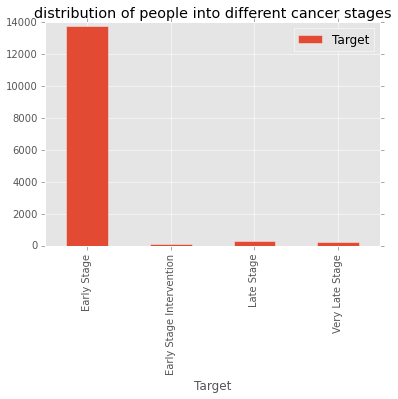

C:\Users\rishab\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


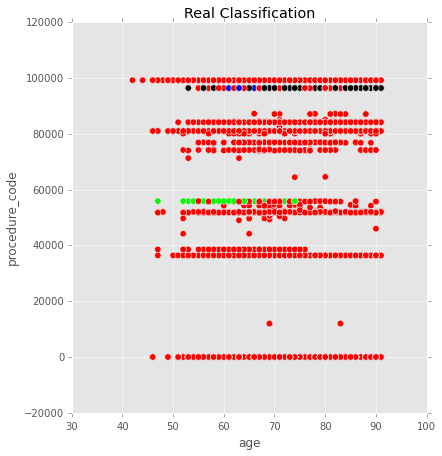

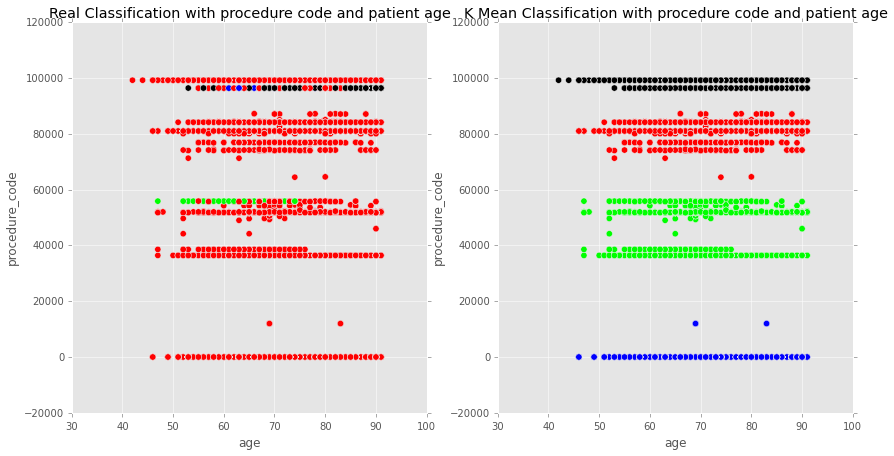

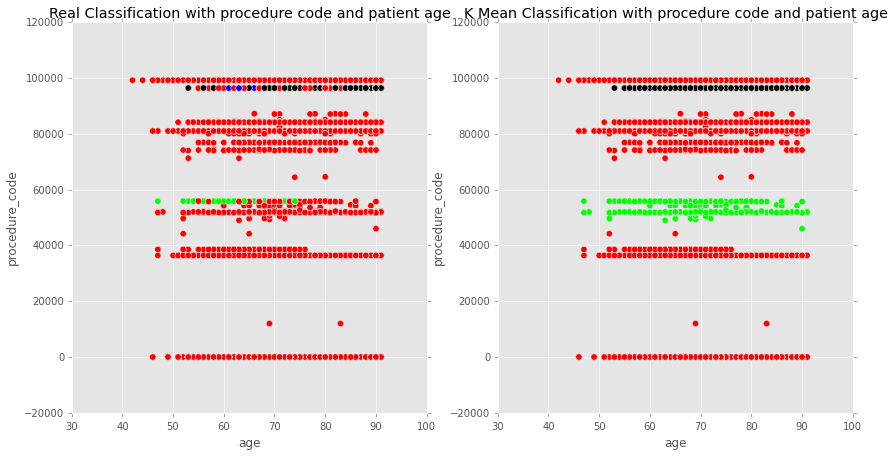

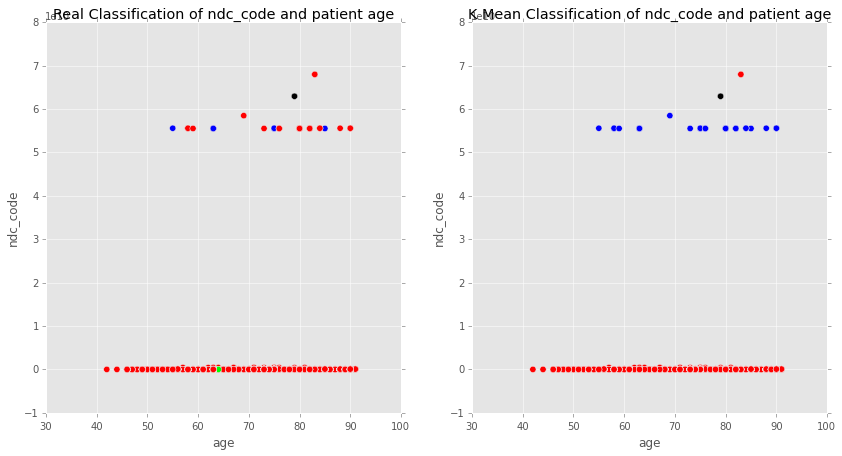

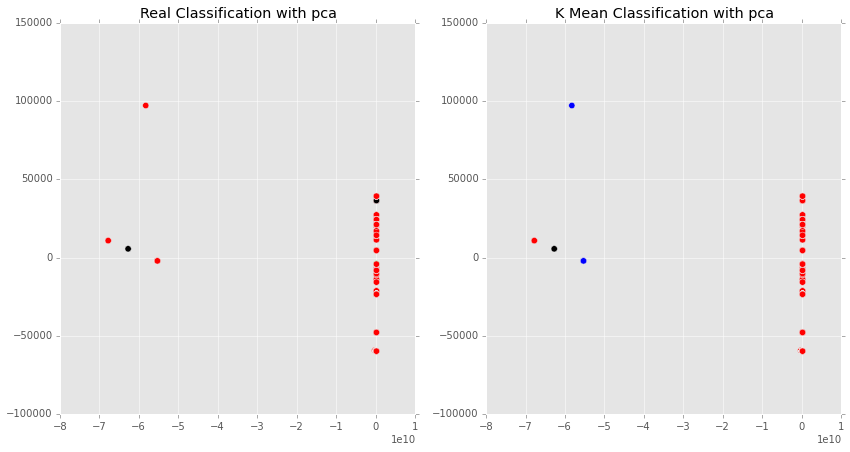

In [1]:
from __future__ import print_function
from math import floor
import os
import subprocess
import pandas as pd
import numpy as np
import pydot
import datetime
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import random
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


#Reading 835_837_NPI.csv file
df=pd.read_csv("835_837_NPI_Reduced.csv")

df = df.fillna(0)

#Filtering out only prostate cancer patients from the csv
df185=df[df['a.dx'].str.contains("185")]
dfC61=df[df['a.dx'].str.contains("C61")]
dfAppended = df185.append(dfC61)

target_values = {
    0 : "Early Stage", 
    1 : "Early Stage Intervention", 
    2 : "Late Stage",
    3 : "Very Late Stage"
}

targets = []
targets_encoded = []
dx = dfAppended['a.dx']
ndc_code = dfAppended['a.ndc_code']
proc_code = dfAppended['a.procedure_code']
strs = ['C79', 'C78', '197', '198']
es_pc = ['96402', '96413', 'J9155', 'J9171', 'J9217', 'J3489']
es_nc = ['00074228203', '00074368303', '00310095130', '52544015302', '55566840301', '62935045245', '62935045345','00024060545',
'00074334603','52544009276','52544015602','62935030330','62935075275','00074210803','00074366303','00024061030',
'00074347303','52544015402','55566830301','62935075375','00024022205','00024079375','00074364203',
'00310095036','62935022305','00069914100','00069914200','00069914400','00075800300','00075800400','00409020100','00703572000',
'00703573000','00955102000','00955102100','16714046500','16714050000','16729012000','16729022800','16729023100','16729026700',
'47335028500','63739093200','63739097100','45963073400','45963076500','45963078100','45963079000','66758005000','66758095000',
'42367012100','43598025800','43598025900','25021022200','00024582400','00024582300','00024582400']

esi_pc = ['77401','77402','77403','77404','77406','77407','77408','77409',
'77411','77412','77413','77414','77416','G6003','G6004','G6005','G6006','G6007',
'G6008','G6009','G6010','G6011','G6012','G6013','G6014','77418','G6015'
'55810','55812','55815','55821','55831','55840','55842','55845','55866','52650','52612','52614']


#Classifying the prostate cancer patients into various stages - Early, Late, etc. based on Prostate_Segmentation.xlsx

for i in range(len(dfAppended)):
    if any(x in dx.iloc[i] for x in strs):
        targets.append(target_values[3])
        targets_encoded.append(3)
    elif any(x in str(proc_code.iloc[i]) for x in es_pc) or any(x in str(ndc_code.iloc[i]) for x in es_nc):
        targets.append(target_values[2])
        targets_encoded.append(2)
    else:
        if any(x in str(proc_code.iloc[i]) for x in esi_pc):
            targets.append(target_values[1])
            targets_encoded.append(1)
        else:
            targets.append(target_values[0])
            targets_encoded.append(0)


target_df = pd.DataFrame({'Target' : targets, 'Target_Encoded' : targets_encoded})

dfAppended.reset_index(drop=True, inplace=True)
target_df.reset_index(drop=True, inplace=True)

#Adding 2 columns to the prostate cancer data - Target (The class like Early stage, etc.) and Target_Encoded (Encoded class)
result = dfAppended.join(target_df)

#Writing the new dataframe to a new csv file.
#result.to_csv('ClassifiedData.csv')

now = datetime.datetime.now()
pat_age = []
pat_gender_code = []
pat_bday = result['a.pat_birthday']
_c22 = result['_c22']

for i in range(len(result)):
    pat_age.append(now.year - pat_bday.iloc[i])
    if _c22.iloc[i] == 'Male':
        pat_gender_code.append(0)
    else:
        pat_gender_code.append(1)
#adding patient age and gender code as number to dataframe
blahdf = pd.DataFrame({'pat_age' : pat_age, 'pat_gender_code' : pat_gender_code})
blahdf.reset_index(drop=True, inplace=True)
result.reset_index(drop=True, inplace=True)
result = result.join(blahdf)
#result.to_csv('ClassifiedDatawithAGE.csv')
#reading the dataset which has only prostrate data
dfcluster=pd.read_csv("classifieddatawithage.csv")
#plotting the number of people in different stages of cancer
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
agegroup=dfcluster[dfcluster['pat_age']>60 ].groupby('Target').agg({'Target':np.size})
agegroup.plot(kind='bar',title='distribution of people into different cancer stages')
#implementing kmeans taking in patient age and procedure_code as parameters and to try clustering into different stages of prostrate cancer
from sklearn.cluster import KMeans
import numpy as np
features =['pat_age', 'procedure_code']
x=dfcluster[features]
y=dfcluster['Target_Encoded']
kmeans = KMeans(n_clusters=4, random_state=0).fit(x)
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black','blue'])
 
#Plot the Original Classifications
plt.subplot(1, 2, 1)
plt.scatter(x.pat_age, x.procedure_code, c=colormap[y], s=40)
plt.xlabel("age")
plt.ylabel("procedure_code")
plt.title('Real Classification')

predY = np.choose(kmeans.labels_,[2,3,1,0]).astype(np.int64)
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black','blue'])
 
#Plot the Original Classifications
plt.subplot(1, 2, 1)
plt.scatter(x.pat_age, x.procedure_code, c=colormap[y], s=40)
plt.xlabel("age")
plt.ylabel("procedure_code")
plt.title('Real Classification with procedure code and patient age ')
 
# Plot the Models Classifications
plt.subplot(1, 2, 2)
plt.scatter(x.pat_age,x.procedure_code, c=colormap[predY], s=40)
plt.xlabel("age")
plt.ylabel("procedure_code")
plt.title('K Mean Classification with procedure code and patient age ')
#accuracy score
import sklearn.metrics as sm
print(sm.accuracy_score(y, predY))
sm.confusion_matrix(y, predY)
#implementing kmeans taking in patient age and procedure_code as parameters and to try clustering into different stages of prostrate cancer
#taking cluster=8 instead of cluster=4
kmeans = KMeans(n_clusters=8, random_state=0).fit(x)
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black','blue','brown','yellow','orange','pink'])
 
#Plot the Original Classifications


predY = np.choose(kmeans.labels_, [0,2,0,0,1,0,0,0]).astype(np.int64)
plt.subplot(1, 2, 1)
plt.scatter(x.pat_age, x.procedure_code, c=colormap[y], s=40)
plt.xlabel("age")
plt.ylabel("procedure_code")
plt.title('Real Classification with procedure code and patient age  ')
 
# Plot the Models Classifications
plt.subplot(1, 2, 2)
plt.scatter(x.pat_age,x.procedure_code, c=colormap[predY], s=40)
plt.xlabel("age")
plt.ylabel("procedure_code")
plt.title('K Mean Classification with procedure code and patient age')

print (kmeans.labels_)
print (predY)
import sklearn.metrics as sm
print(sm.accuracy_score(y, predY))
features =['pat_age', 'ndc_code']
x=dfcluster[features]
y=dfcluster['Target_Encoded']
#implementing kmeans taking in patient age and ndc_code as parameters and to try clustering into different stages of prostrate cancer
kmeans = KMeans(n_clusters=4, random_state=0).fit(x)
predY = np.choose(kmeans.labels_,[0,3,0,2]).astype(np.int64)
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black','blue'])
 
#Plot the Original Classifications
plt.subplot(1, 2, 1)
plt.xlabel("age")
plt.ylabel("ndc_code")
plt.scatter(x.pat_age, x.ndc_code, c=colormap[y], s=40)

plt.title('Real Classification of ndc_code and patient age')
 
# Plot the Models Classifications
plt.subplot(1, 2, 2)
plt.scatter(x.pat_age,x.ndc_code, c=colormap[predY], s=40)
plt.xlabel("age")
plt.ylabel("ndc_code")
plt.title('K Mean Classification of ndc_code and patient age')
from sklearn.decomposition import PCA
features =['pat_age', 'ndc_code','procedure_code']
x=dfcluster[features]
y=dfcluster['Target_Encoded']
kmeans = KMeans(n_clusters=4, random_state=0).fit(x)
plt.figure(figsize=(14,7))
pca_2=PCA(2)
plot_columns = pca_2.fit_transform(x)

 
# Create a colormap
colormap = np.array(['red', 'lime', 'black','blue'])
#plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=colormap[kmeans.labels_],s=40)
predY = np.choose(kmeans.labels_,[0,3,0,2]).astype(np.int64)
 
#Plot the Original Classifications
plt.subplot(1, 2, 1)
plt.scatter(plot_columns[:,0], plot_columns[:,1], c=colormap[y], s=40)
plt.title('Real Classification with pca')
 
# Plot the Models Classifications
plt.subplot(1, 2, 2)
plt.scatter(plot_columns[:,0], plot_columns[:,1], c=colormap[predY], s=40)
plt.title('K Mean Classification with pca ')

In [2]:
plot_columns

array([[  2.05955638e+08,   2.42490705e+04],
       [  2.05955638e+08,   2.42490705e+04],
       [  2.05955638e+08,  -2.34889295e+04],
       ..., 
       [  2.05955638e+08,  -5.99039296e+04],
       [  2.05955638e+08,  -5.99039296e+04],
       [  2.05955638e+08,  -5.99039296e+04]])

In [3]:
plot_columns[0]

array([  2.05955638e+08,   2.42490705e+04])

In [4]:
plot_columns[:,0]

array([  2.05955638e+08,   2.05955638e+08,   2.05955638e+08, ...,
         2.05955638e+08,   2.05955638e+08,   2.05955638e+08])

In [5]:
plot_columns[:,1]

array([ 24249.07045968,  24249.07049   , -23488.92950861, ...,
       -59903.92960607, -59903.92960607, -59903.92960607])